# Process Data

In [1]:
import cv2
import os
from random import shuffle 
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
%matplotlib inline 
import math

In [2]:
#TRAIN_DIR = "D:/Artificial Intelligence/Deep Learning/Fast.ai/dogscats/dogscats/train"
#TEST_DIR = "D:/Artificial Intelligence/Deep Learning/Fast.ai/dogscats/dogscats/valid"
IMG_SIZE = 50
#print(os.listdir(TRAIN_DIR))

### Utils
Functions to load images from train and test directory 

In [3]:
#extract labels from image names
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    if(word_label == 'cat'): 
        return [1,0]
    elif(word_label == 'dog'):
        return [0,1]

In [4]:
# load train data
def create_train_data():
    training_data = []
    for cat in os.listdir(TRAIN_DIR):
        tmp = os.path.join(TRAIN_DIR, cat)
        for img in tqdm(os.listdir(tmp)):
            label = label_img(img)
            path = os.path.join(tmp,img)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [5]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data


In [6]:
#train_X = create_train_data()
train_data = np.load("train_data.npy")
print(train_data.shape)

(23000, 2)


In [7]:
#test_X = process_test_data()
test_data = np.load("valid_data.npy")
print(test_data.shape)

(2000, 2)


#### Plot train samples

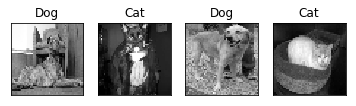

In [8]:
fig = plt.figure()
for num,data in enumerate(train_data[5:9]):
    img_label = data[1]
    img_data = data[0]
    if(img_label[0]==1):
        label = "Cat"
    else:
        label = "Dog"
    y = fig.add_subplot(1,4,num+1)
    orig = img_data
    y.imshow(orig,cmap='gray')
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

#### Train data

In [9]:
train_X = np.array([i[0] for i in train_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
train_Y = np.array([i[1] for i in train_data])
print(train_X.shape)
print(train_Y.shape)

(23000, 50, 50, 1)
(23000, 2)


#### Test data

In [10]:
test_X = np.array([i[0] for i in test_data]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_Y = np.array([i[1] for i in test_data])
print(test_X.shape)
print(test_Y.shape)

(2000, 50, 50, 1)
(2000, 2)


### Create Minibatches

In [11]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    #X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    #Y -- true "label" one-hot vectors  (m, n_y)
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches


# Create Model

In [12]:
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 1. Placeholders to feed data into model

In [13]:
#placeholders
def create_placeholders(n_H, n_W, n_C, n_y):
    
    X = tf.placeholder(dtype = tf.float32, shape = [None, n_H, n_W, n_C],  name = "X")
    Y = tf.placeholder(dtype = tf.float32, shape = [None, n_y] , name = "Y")
    return X, Y

## 2. Init params

In [14]:
def init_params():
    
    W1 = tf.get_variable("W1", [5,5,1,32], initializer = tf.contrib.layers.xavier_initializer(seed = 0) )
    W2 = tf.get_variable("W2", [5,5,32,64], initializer = tf.contrib.layers.xavier_initializer(seed = 0) )
    W3 = tf.get_variable("W3", [5,5,64,128], initializer = tf.contrib.layers.xavier_initializer(seed = 0) )
    W4 = tf.get_variable("W4", [5,5,128,64], initializer = tf.contrib.layers.xavier_initializer(seed = 0) )
    W5 = tf.get_variable("W5", [5,5,64,32], initializer = tf.contrib.layers.xavier_initializer(seed = 0) )
    
    params = {"W1" : W1, "W2" : W2, "W3" : W3, "W4" : W4, "W5" : W5}
    return params

## 3. Forward Propagation

In [15]:
def forward_prop(X, params):
    
    W1 = params['W1']
    W2 = params['W2']
    W3 = params['W3']
    W4 = params['W4']
    W5 = params['W5']
    
    # conv layer - 5 (20*20) filters, s = 1
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    # maxpool - k=5, s=1
    P1 = tf.nn.max_pool(A1, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    
    
    #conv layer - 5 (3*3)filters
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # maxpool - k=5, s=1
    P2 = tf.nn.max_pool(A2, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    
    
    #conv layer - 10 (3*3)filters
    Z3 = tf.nn.conv2d(P2,W3, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A3 = tf.nn.relu(Z3)
    # maxpool - k=5, s=1
    P3 = tf.nn.max_pool(A3, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    
    
    #conv layer - 10 (3*3)filters
    Z4 = tf.nn.conv2d(P3,W4, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A4 = tf.nn.relu(Z4)
    # maxpool - k=5, s=1
    P4 = tf.nn.max_pool(A4, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    
    
    #conv layer - 10 (3*3)filters
    Z5 = tf.nn.conv2d(P4,W5, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A5 = tf.nn.relu(Z5)
    # maxpool - k=5, s=1
    P5 = tf.nn.max_pool(A5, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    
    #flatten
    P5 = tf.contrib.layers.flatten(P5)
        
    #fully connected
    Z6 = tf.contrib.layers.fully_connected(P5, 2, activation_fn=None )
    
    return Z6
    

## 4. Compute Cost

In [16]:
def compute_cost(Z6, Y):
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z6, labels = Y))
    return cost

## 5. Model

In [17]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 1e-4,
          num_epochs = 2, minibatch_size = 128, print_cost = True):
    
    #get shape values
    (m, n_H0, n_W0, n_C0) = X_train.shape 
    n_y = Y_train.shape[1] 
    seed = 3
    
    # list to store costs
    costs = [] 
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    params = init_params()
    Z7 = forward_prop(X, params)
    cost = compute_cost(Z7, Y)
    
    #adadelta optimizer
    optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # get saver instance
    saver = tf.train.Saver()
    
    # tensorboard
    summary = tf.summary.scalar("Cost",cost)
    file_writer = tf.summary.FileWriter("tf_logs/",tf.get_default_graph())
    
    with tf.Session() as sess:
        
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            i=0    
            for minibatch in minibatches:
                i = i + 1
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                #****************  Gradient Descent   ************
                _ , temp_cost = sess.run([optimizer,cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
                
                
                minibatch_cost += temp_cost / num_minibatches
                summary_str = summary.eval(feed_dict={X:minibatch_X, Y:minibatch_Y})
                step = epoch*(m // minibatch_size) + i
                file_writer.add_summary(summary_str, step)
                print ("Cost after iter %i: %f" % (i, temp_cost))
                

            # Print the cost every epoch
            if print_cost == True and epoch % 1 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        # Save the Model
        save_path = saver.save(sess, "./catdogModel")
        print("Model saved in path: %s" % save_path)
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z7, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the  train set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #print(accuracy)
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        file_writer.close()        
        return train_accuracy,test_accuracy, parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after iter 1: 5.633675
Cost after iter 2: 5.840369
Cost after iter 3: 5.891269
Cost after iter 4: 4.970100
Cost after iter 5: 4.582146
Cost after iter 6: 6.546707
Cost after iter 7: 6.690149
Cost after iter 8: 6.255649
Cost after iter 9: 6.084479
Cost after iter 10: 5.391655
Cost after iter 11: 5.311885
Cost after iter 12: 4.725007
Cost after iter 13: 5.139476
Cost after iter 14: 5.127463
Cost after iter 15: 5.229580
Cost after iter 16: 5.043386
Cost after iter 17: 5.305744
Cost after iter 18: 4.371604
Cost after iter 19: 5.149528
Cost after iter 20: 5.220217
Cost after iter 21: 5.181392
Cost after iter 22: 4.184368
Cost after iter 23: 4.558116
Cost after iter 24: 5.011650
Cost after iter 25: 4.915847
Cost after iter 26: 3.578231
Cost after iter 27: 4.276316
Cost after iter 28: 4.153345
Cost 

Cost after iter 88: 2.125278
Cost after iter 89: 1.879924
Cost after iter 90: 2.463083
Cost after iter 91: 2.706321
Cost after iter 92: 2.466590
Cost after iter 93: 2.351329
Cost after iter 94: 2.779375
Cost after iter 95: 2.070880
Cost after iter 96: 2.089717
Cost after iter 97: 2.953149
Cost after iter 98: 2.190259
Cost after iter 99: 2.830742
Cost after iter 100: 2.819043
Cost after iter 101: 2.532098
Cost after iter 102: 2.586173
Cost after iter 103: 2.280681
Cost after iter 104: 1.934412
Cost after iter 105: 2.627288
Cost after iter 106: 2.186705
Cost after iter 107: 3.354099
Cost after iter 108: 2.399062
Cost after iter 109: 2.612229
Cost after iter 110: 2.428869
Cost after iter 111: 3.063407
Cost after iter 112: 3.073228
Cost after iter 113: 2.917010
Cost after iter 114: 2.226883
Cost after iter 115: 2.812657
Cost after iter 116: 2.298258
Cost after iter 117: 2.707040
Cost after iter 118: 2.298419
Cost after iter 119: 3.027121
Cost after iter 120: 2.671252
Cost after iter 121: 2

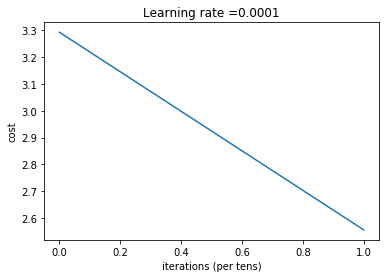

ResourceExhaustedError: OOM when allocating tensor with shape[23000,32,50,50] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, W1/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Flatten/flatten/Shape/_71 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_34_Flatten/flatten/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Conv2D', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.6/dist-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-287dfbfd629d>", line 1, in <module>
    _,_, parameters = model(train_X, train_Y, test_X, test_Y)
  File "<ipython-input-17-f0e461788438>", line 14, in model
    Z7 = forward_prop(X, params)
  File "<ipython-input-15-00348d495c06>", line 10, in forward_prop
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 956, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[23000,32,50,50] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: Conv2D = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer, W1/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: Flatten/flatten/Shape/_71 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_34_Flatten/flatten/Shape", tensor_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [18]:
_,_, parameters = model(train_X, train_Y, test_X, test_Y)